# Análise PySpark – Fórmula 1 (Star Schema)

Este notebook carrega os CSVs de `Data Layer/raw/dados_originais`, trata `lap_times.csv` como fato e as demais como dimensões, e gera gráficos de barras, pizza, regressão e análise de outliers.

In [72]:
# Imports e configuração do PySpark e visualização
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

import numpy as np
import matplotlib.pyplot as plt

import os, sys, subprocess

# Forçar JAVA_HOME para JDK 17 (macOS)
try:
    import os, subprocess
    java17_candidates = [
        '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/zulu-17.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/corretto-17.jdk/Contents/Home',
    ]
    _set = False
    for _p in java17_candidates:
        if os.path.exists(os.path.join(_p, 'bin', 'java')):
            os.environ['JAVA_HOME'] = _p
            _set = True
            break
    if not _set:
        # fallback para detecção do sistema restrita ao 17
        os.environ['JAVA_HOME'] = subprocess.check_output(['/usr/libexec/java_home','-v','17']).decode().strip()
    os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ.get('PATH','')
    os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'
    print('JAVA_HOME (forçado 17): ' + os.environ['JAVA_HOME'])
except Exception as _e:
    print('Aviso: não foi possível definir JAVA_HOME (JDK 17): ' + str(_e))




# Visual config (seaborn optional)
try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except Exception:
    try:
        plt.style.use('seaborn-whitegrid')
    except Exception:
        plt.style.use('ggplot')



spark = (
    SparkSession
        .builder
        .master('local[*]')
        .appName('F1 Analytics - PySpark')
)

BASE_DIR = 'Data Layer/raw/dados_originais'
print(f'Base de dados: {BASE_DIR}')

JAVA_HOME (forçado 17): /opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home
Base de dados: Data Layer/raw/dados_originais


In [73]:
# Carregamento dos CSVs como DataFrames do Spark
# Forçar Java 17 e iniciar Spark sem getOrCreate
import os, sys, subprocess, tempfile, time

def _set_java17():
    candidates = [
        '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/temurin-17.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/zulu-17.jdk/Contents/Home',
        '/Library/Java/JavaVirtualMachines/corretto-17.jdk/Contents/Home',
    ]
    for p in candidates:
        if os.path.exists(os.path.join(p, 'bin', 'java')):
            os.environ['JAVA_HOME'] = p
            break
    if 'JAVA_HOME' not in os.environ:
        try:
            os.environ['JAVA_HOME'] = subprocess.check_output(['/usr/libexec/java_home','-v','17']).decode().strip()
        except Exception:
            pass
    if 'JAVA_HOME' in os.environ:
        os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ.get('PATH','')
        os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'
        print('JAVA_HOME (forçado 17): ' + os.environ['JAVA_HOME'])

_set_java17()

from pyspark.sql import SparkSession as _SparkSession
from pyspark import SparkContext as _SparkContext, SparkConf as _SparkConf

# parar contexto antigo se existir (evita conflitos)
if _SparkContext._active_spark_context is not None:
    try:
        _SparkContext._active_spark_context.stop()
        time.sleep(1)
    except Exception:
        pass

conf = (_SparkConf()
        .setMaster('local[*]')
        .setAppName('F1 Analytics - PySpark')
        .set('spark.ui.enabled','false')
        .set('spark.driver.host','127.0.0.1')
        .set('spark.local.dir', tempfile.gettempdir()))
sc = _SparkContext(conf=conf)
spark = _SparkSession(sc)

# Resolver BASE_DIR absoluto (prioriza a pasta no nível acima do Notebooks)
import os as _os
_cwd = _os.getcwd()
_cand_parent = _os.path.abspath(_os.path.join(_cwd, '..', 'Data Layer', 'raw', 'dados_originais'))
_cand_here = _os.path.join(_cwd, 'Data Layer', 'raw', 'dados_originais')
if _os.path.exists(_cand_parent):
    BASE_DIR = _cand_parent
elif _os.path.exists(_cand_here):
    BASE_DIR = _cand_here
else:
    raise FileNotFoundError('Não encontrei a pasta de dados. Esperado em ../Data Layer/raw/dados_originais')
print('Base de dados:', BASE_DIR)

def read_csv(name: str):
    path = f'{BASE_DIR}/{name}.csv'
    return (
        spark.read
        .option('header', 'true')
        .option('inferSchema', 'true')
        .csv(path)
    )

dfs = {
    'lap_times': read_csv('lap_times'),
    'drivers': read_csv('drivers'),
    'races': read_csv('races'),
    'circuits': read_csv('circuits'),
    'results': read_csv('results'),
    'constructors': read_csv('constructors'),
    'qualifying': read_csv('qualifying'),
    'seasons': read_csv('seasons'),
    'status': read_csv('status'),
    'pit_stops': read_csv('pit_stops'),
    'driver_standings': read_csv('driver_standings'),
    'constructor_standings': read_csv('constructor_standings'),
    'constructor_results': read_csv('constructor_results'),
    'sprint_results': read_csv('sprint_results'),
}

for name in sorted(dfs):
    print(f'Tabela: {name}')
    dfs[name].printSchema()
    print('Registros:', dfs[name].count())


JAVA_HOME (forçado 17): /opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home


25/09/26 18:48:16 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Base de dados: /Users/kalebmacedo/formula1-analytics-2/Data Layer/raw/dados_originais
Tabela: circuits
root
 |-- circuitId: integer (nullable = true)
 |-- circuitRef: string (nullable = true)
 |-- name: string (nullable = true)
 |-- location: string (nullable = true)
 |-- country: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- alt: integer (nullable = true)
 |-- url: string (nullable = true)

Registros: 77
Tabela: constructor_results
root
 |-- constructorResultsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- status: string (nullable = true)

Registros: 12625
Tabela: constructor_standings
root
 |-- constructorStandingsId: integer (nullable = true)
 |-- raceId: integer (nullable = true)
 |-- constructorId: integer (nullable = true)
 |-- points: double (nullable = true)
 |-- position: integer (nullable = true)
 |-- positionText:

In [74]:
# Construção da fato enriquecida (lap_times + dimensões relevantes)
lt = dfs['lap_times'].alias('lt')
r = dfs['races'].alias('r')
d = dfs['drivers'].alias('d')

fact = (
    lt.join(r, F.col('lt.raceId') == F.col('r.raceId'), 'left')
      .join(d, F.col('lt.driverId') == F.col('d.driverId'), 'left')
      .withColumn('driver_full_name', F.concat_ws(' ', F.col('d.forename'), F.col('d.surname')))
      .select(
          F.col('r.year').alias('year'),
          F.col('r.round').alias('round'),
          F.col('lt.raceId').alias('raceId'),
          F.col('r.circuitId').alias('circuitId'),
          F.col('lt.driverId').alias('driverId'),
          F.col('driver_full_name'),
          F.col('lt.lap').cast('int').alias('lap'),
          F.col('lt.position').cast('int').alias('position'),
          F.col('lt.time').alias('time_str'),
          F.col('lt.milliseconds').cast('double').alias('milliseconds')
      )
)

print('Registros fato enriquecida:', fact.count())
fact.orderBy('year','round','lap').limit(5).show(truncate=False)


Registros fato enriquecida: 589081
+----+-----+------+---------+--------+------------------+---+--------+--------+------------+
|year|round|raceId|circuitId|driverId|driver_full_name  |lap|position|time_str|milliseconds|
+----+-----+------+---------+--------+------------------+---+--------+--------+------------+
|1996|1    |224   |1        |77      |Gerhard Berger    |1  |9       |1:49.726|109726.0    |
|1996|1    |224   |1        |14      |David Coulthard   |1  |19      |1:56.926|116926.0    |
|1996|1    |224   |1        |71      |Damon Hill        |1  |2       |1:44.243|104243.0    |
|1996|1    |224   |1        |55      |Jean Alesi        |1  |5       |1:46.506|106506.0    |
|1996|1    |224   |1        |35      |Jacques Villeneuve|1  |1       |1:43.702|103702.0    |
+----+-----+------+---------+--------+------------------+---+--------+--------+------------+



In [75]:
# Seleção de ano e corrida padrão (mais recente disponível)
latest = (fact
    .groupBy('year')
    .agg(F.max('round').alias('max_round'))
    .orderBy(F.col('year').desc())
)
sel = latest.limit(1).collect()[0]
selected_year = int(sel['year'])
selected_round = int(sel['max_round'])

selected_race = (fact
    .filter((F.col('year') == selected_year) & (F.col('round') == selected_round))
)

print(f'Ano selecionado: {selected_year} | Etapa (round): {selected_round}')
print('Registros na corrida selecionada:', selected_race.count())
selected_race.orderBy('lap').limit(5).show(truncate=False)


Ano selecionado: 2024 | Etapa (round): 24
Registros na corrida selecionada: 1033
+----+-----+------+---------+--------+----------------+---+--------+--------+------------+
|year|round|raceId|circuitId|driverId|driver_full_name|lap|position|time_str|milliseconds|
+----+-----+------+---------+--------+----------------+---+--------+--------+------------+
|2024|24   |1144  |24       |847     |George Russell  |1  |4       |1:34.679|94679.0     |
|2024|24   |1144  |24       |844     |Charles Leclerc |1  |8       |1:37.644|97644.0     |
|2024|24   |1144  |24       |807     |Nico Hülkenberg |1  |5       |1:35.498|95498.0     |
|2024|24   |1144  |24       |842     |Pierre Gasly    |1  |3       |1:33.984|93984.0     |
|2024|24   |1144  |24       |4       |Fernando Alonso |1  |6       |1:36.166|96166.0     |
+----+-----+------+---------+--------+----------------+---+--------+--------+------------+



## Gráfico de Barras: média de tempo de volta por piloto (corrida selecionada)

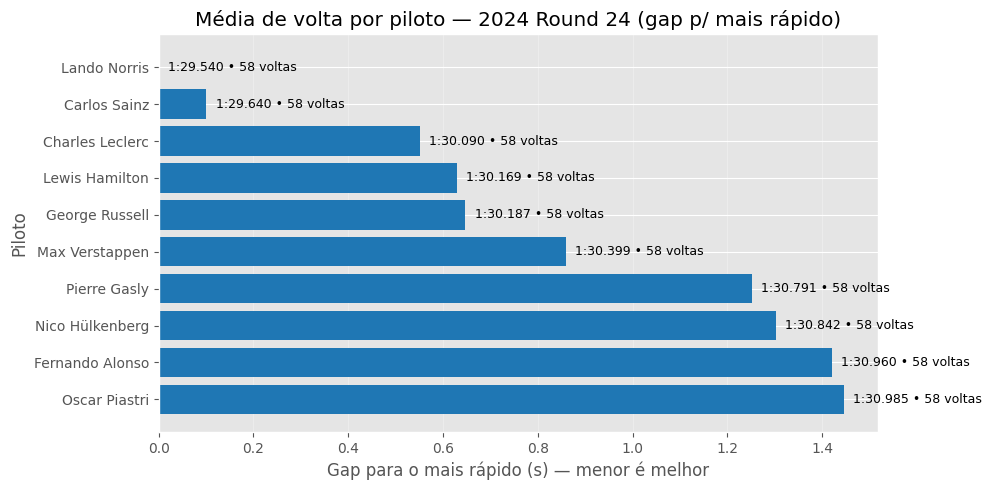

In [76]:
# Média por piloto (TOP_N) com gap para o mais rápido e anotações úteis
TOP_N = 10
stats = (selected_race
    .where(F.col('milliseconds').isNotNull())
    .groupBy('driver_full_name')
    .agg(F.avg('milliseconds').alias('avg_ms'), F.count('*').alias('laps'))
    .orderBy(F.col('avg_ms').asc())
)
rows = stats.limit(TOP_N).collect()
names = [r['driver_full_name'] for r in rows]
avg_ms = [float(r['avg_ms']) for r in rows]
laps = [int(r['laps']) for r in rows]
if not avg_ms:
    print('Sem dados de volta para plotar.')
else:
    fastest = min(avg_ms)
    gaps_s = [(v - fastest) / 1000.0 for v in avg_ms]
    avgs_s = [v / 1000.0 for v in avg_ms]

    def _fmt_ms(ms):
        s = ms / 1000.0
        m = int(s // 60)
        sec = s - 60 * m
        return f"{m:d}:{sec:06.3f}"

    plt.figure(figsize=(10, 5))
    colors = ['#1f77b4' if i != 0 else '#2ca02c' for i in range(len(names))]  # destaca o mais rápido
    bars = plt.barh(names, gaps_s, color=colors)
    plt.gca().invert_yaxis()  # mais rápido no topo (gap = 0)

    # anotações: tempo médio formatado + nº de voltas
    for i, b in enumerate(bars):
        label = f"{_fmt_ms(avg_ms[i])} • {laps[i]} voltas"
        plt.text(b.get_width() + 0.02, b.get_y() + b.get_height()/2, label, va='center', fontsize=9)

    plt.title(f'Média de volta por piloto — {selected_year} Round {selected_round} (gap p/ mais rápido)')
    plt.xlabel('Gap para o mais rápido (s) — menor é melhor')
    plt.ylabel('Piloto')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


## Gráfico de Pizza: distribuição de voltas por piloto (corrida selecionada)

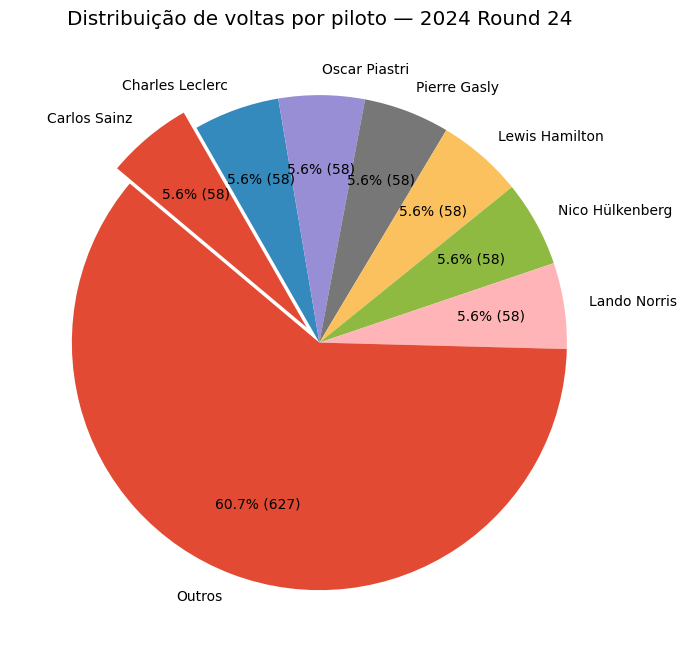

In [77]:
# Gráfico de Pizza: distribuição de voltas por piloto (corrida selecionada) — sem pandas
laps_by_driver = (selected_race
    .groupBy('driver_full_name')
    .agg(F.count('*').alias('laps'))
    .orderBy(F.col('laps').desc())
)
# Coleta e prepara os dados para pizza
rows = [(r['driver_full_name'], int(r['laps'])) for r in laps_by_driver.collect()]
rows.sort(key=lambda t: t[1], reverse=True)
MAX_SLICES = 8
if len(rows) > MAX_SLICES:
    top = rows[:MAX_SLICES-1]
    others_sum = sum(v for _, v in rows[MAX_SLICES-1:])
    rows = top + [('Outros', others_sum)]
names = [n for n, _ in rows]
values = [v for _, v in rows]
if not values or sum(values) == 0:
    print('Sem voltas para plotar nesta corrida.')
else:
    def _autopct(values):
        total = float(sum(values))
        def fmt(pct):
            v = int(round(pct * total / 100.0))
            return f'{pct:.1f}% ({v})'
        return fmt
    plt.figure(figsize=(7, 7))
    explode = [0.08] + [0] * (len(values) - 1) if values else None
    plt.pie(values, labels=names, autopct=_autopct(values), explode=explode, startangle=140, counterclock=False, pctdistance=0.7)
    plt.title(f'Distribuição de voltas por piloto — {selected_year} Round {selected_round}')
    plt.tight_layout()
    plt.show()


## Regressão Linear: Lap (X) vs Milliseconds (Y) – corrida selecionada

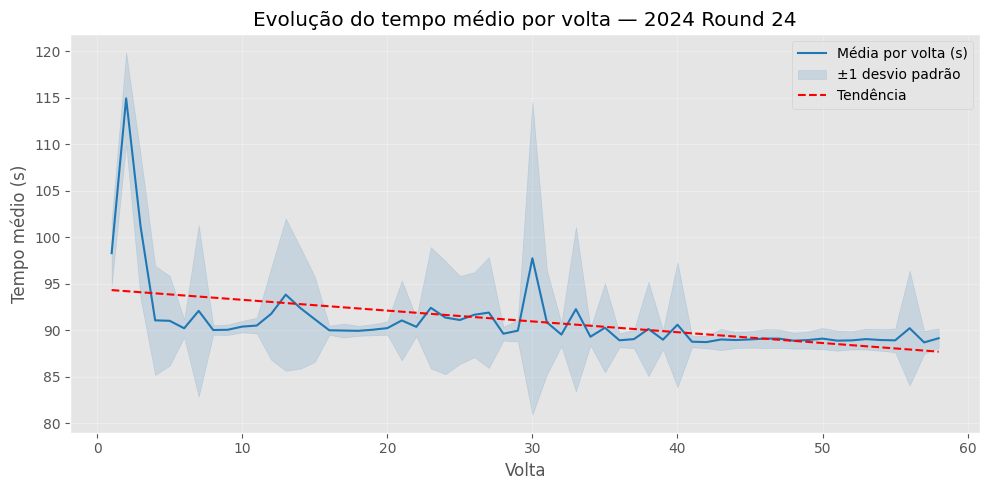

In [78]:
# Evolução do tempo médio por volta (com variabilidade) — sem pandas
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as _SparkSession
import numpy as np
import matplotlib.pyplot as plt

# Requer sessão Spark e selected_race já definidas (células 1–4)
if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessão Spark não encontrada. Execute as células 1–4 antes desta.')
if 'selected_race' not in globals():
    raise RuntimeError('selected_race não encontrada. Execute até a 4ª célula.')

df = selected_race.where(F.col('milliseconds').isNotNull())
by_lap = (df.groupBy('lap')
           .agg(F.avg('milliseconds').alias('avg_ms'), F.stddev('milliseconds').alias('std_ms'))
           .orderBy('lap'))
rows = by_lap.collect()
if not rows:
    print('Sem dados para plotar.')
else:
    laps = [int(r['lap']) for r in rows]
    avg = [float(r['avg_ms']) for r in rows]
    std = [float(r['std_ms']) if r['std_ms'] is not None else 0.0 for r in rows]
    avg_s = [v/1000.0 for v in avg]
    std_s = [v/1000.0 for v in std]
    plt.figure(figsize=(10,5))
    plt.plot(laps, avg_s, color='#1f77b4', label='Média por volta (s)')
    upper = [a+s for a,s in zip(avg_s, std_s)]
    lower = [max(0.0, a-s) for a,s in zip(avg_s, std_s)]
    plt.fill_between(laps, lower, upper, color='#1f77b4', alpha=0.15, label='±1 desvio padrão')
    # Tendência linear simples na média
    try:
        x = np.array(laps, dtype=float)
        y = np.array(avg_s, dtype=float)
        coef = np.polyfit(x, y, 1)
        y_fit = coef[0]*x + coef[1]
        plt.plot(laps, y_fit, color='red', linewidth=1.5, linestyle='--', label='Tendência')
    except Exception:
        pass
    plt.title(f'Evolução do tempo médio por volta — {selected_year} Round {selected_round}')
    plt.xlabel('Volta')
    plt.ylabel('Tempo médio (s)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Outliers e Linha (Index X vs Coluna Y)

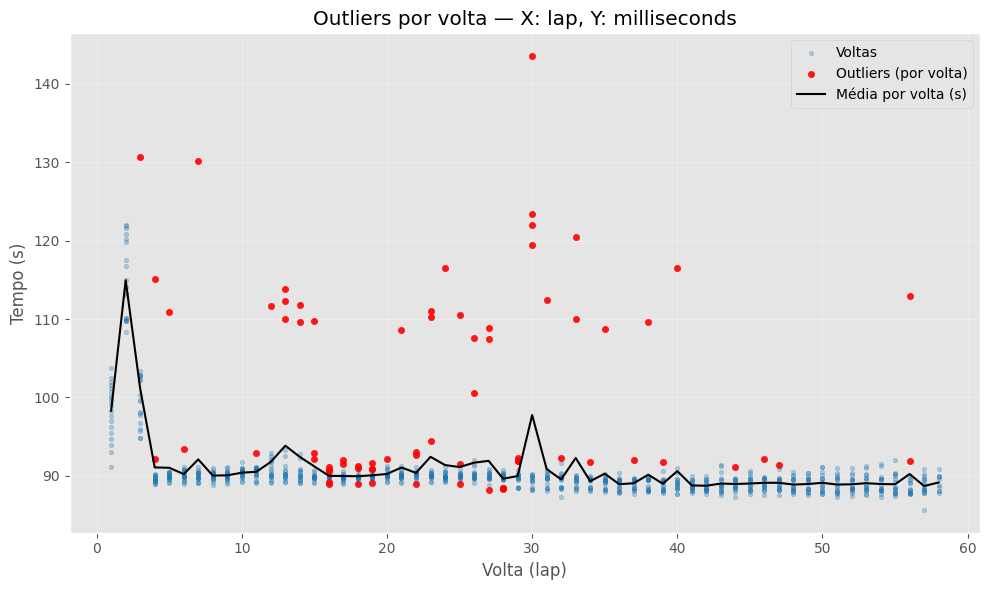

In [79]:
# Outliers por volta (lap): X=lap, Y=milliseconds; destaca outliers por volta (z-score e IQR)
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession as _SparkSession
import numpy as np
import matplotlib.pyplot as plt

if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessão Spark não encontrada. Execute as células 1–4 primeiro.')
if 'selected_race' not in globals():
    raise RuntimeError('selected_race não encontrada. Execute até a 4ª célula.')

COLUMN_TO_ANALYZE = 'milliseconds'
Z_THRESHOLD = 3.0

base = (selected_race
    .select('lap', F.col(COLUMN_TO_ANALYZE).cast('double').alias('y'))
    .where(F.col('y').isNotNull())
)
# Estatísticas por volta: média, desvio, Q1, Q3
stats = (base.groupBy('lap')
    .agg(
        F.avg('y').alias('mean_lap'),
        F.stddev('y').alias('std_lap'),
        F.expr('percentile_approx(y, 0.25)').alias('q1'),
        F.expr('percentile_approx(y, 0.75)').alias('q3'),
        F.count('*').alias('n')
    )
)
joined = (base.alias('b')
    .join(stats.alias('s'), on='lap', how='left')
    .withColumn('iqr', F.col('s.q3') - F.col('s.q1'))
    .withColumn('z', F.when(F.col('s.std_lap') > 0, (F.col('b.y') - F.col('s.mean_lap')) / F.col('s.std_lap')).otherwise(F.lit(0.0)))
    .withColumn('is_out_iqr', (F.col('b.y') < (F.col('s.q1') - 1.5*F.col('iqr'))) | (F.col('b.y') > (F.col('s.q3') + 1.5*F.col('iqr'))))
    .withColumn('is_out_z', F.abs(F.col('z')) > F.lit(Z_THRESHOLD))
    .withColumn('is_outlier', F.col('is_out_iqr') | F.col('is_out_z'))
)
# Coleta para plot — limite para evitar excesso de pontos
MAX_POINTS = 50000
rows = (joined
    .select('lap','y','is_outlier','s.mean_lap')
    .orderBy('lap', 'y')
    .limit(MAX_POINTS)
    .collect())
if not rows:
    print('Sem dados para plotar.')
else:
    laps = [int(r['lap']) for r in rows]
    ys = [float(r['y']) for r in rows]
    outs = [bool(r['is_outlier']) for r in rows]
    # médias por volta para linha
    mean_by_lap_rows = stats.orderBy('lap').select('lap','mean_lap').collect()
    laps_m = [int(r['lap']) for r in mean_by_lap_rows]
    mean_m = [float(r['mean_lap'])/1000.0 for r in mean_by_lap_rows]
    # valores em segundos
    ys_s = [v/1000.0 for v in ys]
    plt.figure(figsize=(10,6))
    # pontos: não outliers (azul claro), outliers (vermelho)
    x_no = [x for x,o in zip(laps, outs) if not o]
    y_no = [y for y,o in zip(ys_s, outs) if not o]
    x_ou = [x for x,o in zip(laps, outs) if o]
    y_ou = [y for y,o in zip(ys_s, outs) if o]
    if x_no:
        plt.scatter(x_no, y_no, s=10, alpha=0.3, color='#1f77b4', label='Voltas')
    if x_ou:
        plt.scatter(x_ou, y_ou, s=20, alpha=0.9, color='red', label='Outliers (por volta)')
    # linha da média por volta
    if laps_m:
        plt.plot(laps_m, mean_m, color='black', linewidth=1.5, label='Média por volta (s)')
    plt.title(f'Outliers por volta — X: lap, Y: {COLUMN_TO_ANALYZE}')
    plt.xlabel('Volta (lap)')
    plt.ylabel('Tempo (s)')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


O que o gráfico mostra agora

  - X = lap (número da volta).
  - Y = tempo da volta em segundos (milliseconds/1000).
  - Pontos azuis: todas as voltas dos pilotos naquela corrida.
  - Pontos vermelhos: outliers por volta, detectados via duas regras:
      - Z-score por volta: |(tempo − média da volta)/desvio da volta| > Z_THRESHOLD
  (padrão 3.0).
      - IQR por volta: fora do intervalo [Q1 − 1.5·IQR, Q3 + 1.5·IQR] daquela volta.
  - Linha preta: média por volta (s), para contexto de ritmo da corrida.

  Por que faz sentido

  - Compara cada volta a seus pares na mesma volta (não com a corrida inteira), isolando
  voltas “fora da curva” naquele momento da prova.
  - Em voltas de pit stop, incidentes ou safety car, os pontos tendem a se destacar como
  outliers.
  - A linha de média mostra a evolução típica por volta, e os vermelhos indicam desvios
  individuais relevantes.

  Parâmetros ajustáveis

  - Z_THRESHOLD: 3.0 por padrão; reduza para 2.5/2.0 para detectar mais pontos.
  - COLUMN_TO_ANALYZE: ficou ‘milliseconds’; se quiser outra métrica numérica, é só
  trocar.

Piloto selecionado: Fernando Alonso (driverId=4)


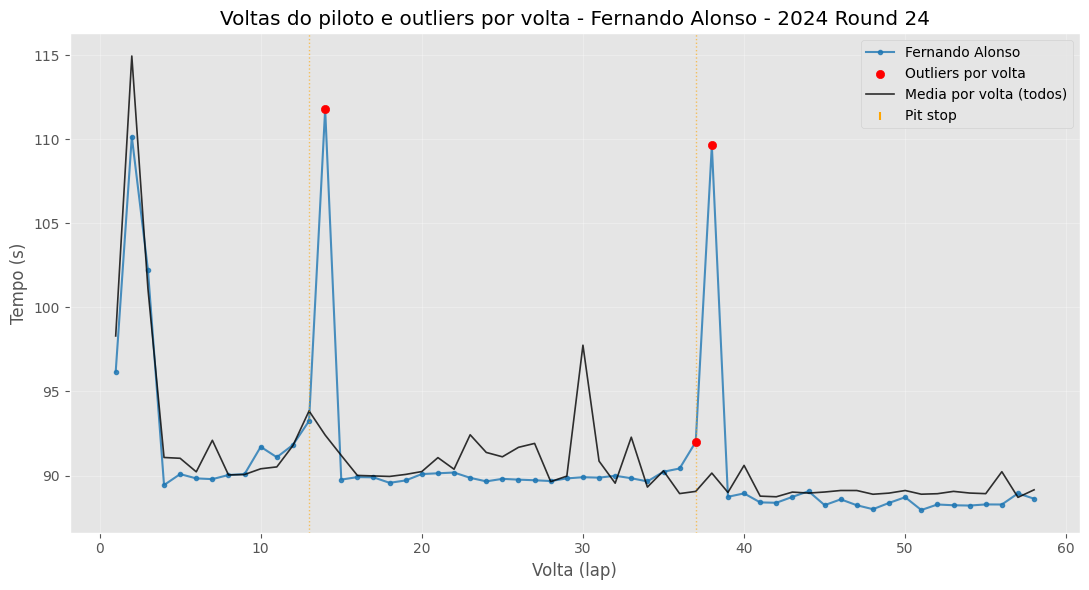

In [80]:
# Outliers por volta para um piloto específico, com marcação de pit stops (sem pandas)
from pyspark.sql import functions as F, Window
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt
import numpy as np

if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4 antes desta.')
if 'selected_race' not in globals() or 'dfs' not in globals():
    raise RuntimeError('Variaveis necessarias nao encontradas. Execute as celulas 2-4.')

DRIVER_NAME = None  # Ex.: 'Lewis Hamilton'; None -> escolhe piloto com mais voltas
COLUMN_TO_ANALYZE = 'milliseconds'
Z_THRESHOLD = 3.0

if DRIVER_NAME is None:
    top = (selected_race
        .groupBy('driver_full_name','driverId')
        .agg(F.count('*').alias('laps'))
        .orderBy(F.col('laps').desc())
        .limit(1)
        .collect())
    if not top:
        raise RuntimeError('Nao ha voltas na corrida selecionada.')
    DRIVER_NAME = top[0]['driver_full_name']
    DRIVER_ID = int(top[0]['driverId'])
else:
    di = (selected_race
        .filter(F.col('driver_full_name') == DRIVER_NAME)
        .select('driverId')
        .limit(1)
        .collect())
    if not di:
        raise RuntimeError('Piloto nao encontrado na corrida selecionada: ' + str(DRIVER_NAME))
    DRIVER_ID = int(di[0]['driverId'])
print('Piloto selecionado: ' + DRIVER_NAME + ' (driverId=' + str(DRIVER_ID) + ')')

base_all = (selected_race
    .select('lap', F.col(COLUMN_TO_ANALYZE).cast('double').alias('y'))
    .where(F.col('y').isNotNull())
)
lap_stats = (base_all.groupBy('lap')
    .agg(F.avg('y').alias('mean_lap'), F.stddev('y').alias('std_lap'),
         F.expr('percentile_approx(y, 0.25)').alias('q1'), F.expr('percentile_approx(y, 0.75)').alias('q3'),
         F.count('*').alias('n'))
)
driver_df = (selected_race
    .filter(F.col('driverId') == DRIVER_ID)
    .select('lap', F.col(COLUMN_TO_ANALYZE).cast('double').alias('y'))
    .where(F.col('y').isNotNull())
)
joined = (driver_df.alias('b')
    .join(lap_stats.alias('s'), on='lap', how='left')
    .withColumn('iqr', F.col('s.q3') - F.col('s.q1'))
    .withColumn('z', F.when(F.col('s.std_lap') > 0, (F.col('b.y') - F.col('s.mean_lap')) / F.col('s.std_lap')).otherwise(F.lit(0.0)))
    .withColumn('is_out_iqr', (F.col('b.y') < (F.col('s.q1') - 1.5*F.col('iqr'))) | (F.col('b.y') > (F.col('s.q3') + 1.5*F.col('iqr'))))
    .withColumn('is_out_z', F.abs(F.col('z')) > F.lit(Z_THRESHOLD))
    .withColumn('is_outlier', F.col('is_out_iqr') | F.col('is_out_z'))
)
rows = joined.orderBy('lap').collect()
laps = [int(r['lap']) for r in rows]
ys = [float(r['y'])/1000.0 for r in rows]
outs = [bool(r['is_outlier']) for r in rows]
means = {int(r['lap']): float(r['mean_lap'])/1000.0 for r in lap_stats.select('lap','mean_lap').collect()}
raceId_val = int(selected_race.select('raceId').limit(1).collect()[0]['raceId'])
pit_df = dfs.get('pit_stops')
pit_laps = []
if pit_df is not None:
    pit_rows = (pit_df.filter((F.col('raceId') == raceId_val) & (F.col('driverId') == DRIVER_ID))
        .select('lap').distinct().orderBy('lap').collect())
    pit_laps = [int(r['lap']) for r in pit_rows]

plt.figure(figsize=(11,6))
if laps:
    plt.plot(laps, ys, '-o', markersize=3, alpha=0.8, color='#1f77b4', label=DRIVER_NAME)
    x_ou = [x for x,o in zip(laps, outs) if o]
    y_ou = [y for y,o in zip(ys, outs) if o]
    if x_ou:
        plt.scatter(x_ou, y_ou, s=35, color='red', zorder=3, label='Outliers por volta')
    laps_sorted = sorted(means.keys())
    mean_series = [means[l] for l in laps_sorted]
    if laps_sorted:
        plt.plot(laps_sorted, mean_series, color='black', linewidth=1.2, alpha=0.8, label='Media por volta (todos)')
    pit_labeled = False
    for lp in pit_laps:
        plt.axvline(x=lp, color='orange', linestyle=':', alpha=0.6, linewidth=1)
        if not pit_labeled:
            plt.scatter([], [], color='orange', marker='|', label='Pit stop')
            pit_labeled = True
plt.title('Voltas do piloto e outliers por volta - ' + DRIVER_NAME + ' - ' + str(selected_year) + ' Round ' + str(selected_round))
plt.xlabel('Volta (lap)')
plt.ylabel('Tempo (s)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


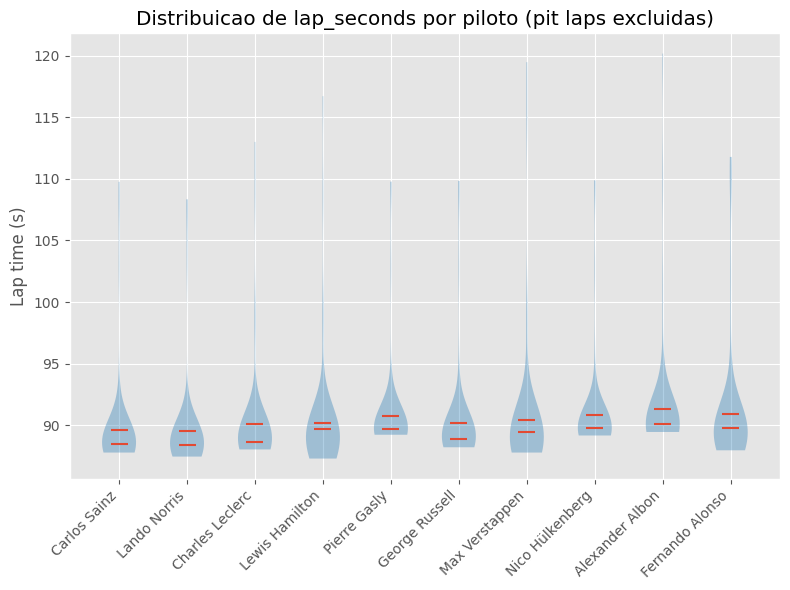

In [81]:
# Boxplot por piloto: distribuicao de lap_seconds (exclui pit laps)
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt

if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals() or 'dfs' not in globals():
    raise RuntimeError('Variaveis necessarias nao encontradas. Execute as celulas 2-4.')

TOP_DRIVERS = 10
EXCLUDE_PIT_LAPS = True

df = (selected_race
    .select('driver_full_name','driverId','lap', (F.col('milliseconds')/1000.0).alias('lap_s'))
    .where(F.col('lap_s').isNotNull())
)
if EXCLUDE_PIT_LAPS and dfs.get('pit_stops') is not None:
    raceId_val = int(selected_race.select('raceId').limit(1).collect()[0]['raceId'])
    pit = (dfs['pit_stops']
        .filter(F.col('raceId') == raceId_val)
        .select('driverId','lap')
        .distinct())
    df = df.join(pit, on=['driverId','lap'], how='left_anti')

top = (df.groupBy('driver_full_name','driverId')
    .agg(F.count('*').alias('laps'))
    .orderBy(F.col('laps').desc())
    .limit(TOP_DRIVERS)
    .collect())
driver_ids = [int(r['driverId']) for r in top]
driver_names = [r['driver_full_name'] for r in top]

series = []
labels = []
for did, name in zip(driver_ids, driver_names):
    vals = [float(r['lap_s']) for r in df.filter(F.col('driverId') == did).select('lap_s').collect()]
    if vals:
        series.append(vals)
        labels.append(name)

plt.figure(figsize=(max(8, int(len(series)*0.7)), 6))
parts = plt.violinplot(series, showmeans=True, showmedians=True, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_alpha(0.35)
# X-ticks com nomes dos pilotos
plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=45, ha='right')
plt.ylabel('Lap time (s)')
plt.title('Distribuicao de lap_seconds por piloto (pit laps excluidas)')
plt.tight_layout()
plt.show()


- Violin mostra a densidade da distribuição de tempos por piloto (mais
  “gordinho” onde há mais voltas).
- Mediana e média são marcadas para referência.
- Mantém a exclusão de voltas de pit (se pit_stops existir).

Mostra: distribuição do pace (mediana, dispersão, cauda).
Pergunta: quem foi consistente e quem teve voltas erráticas?

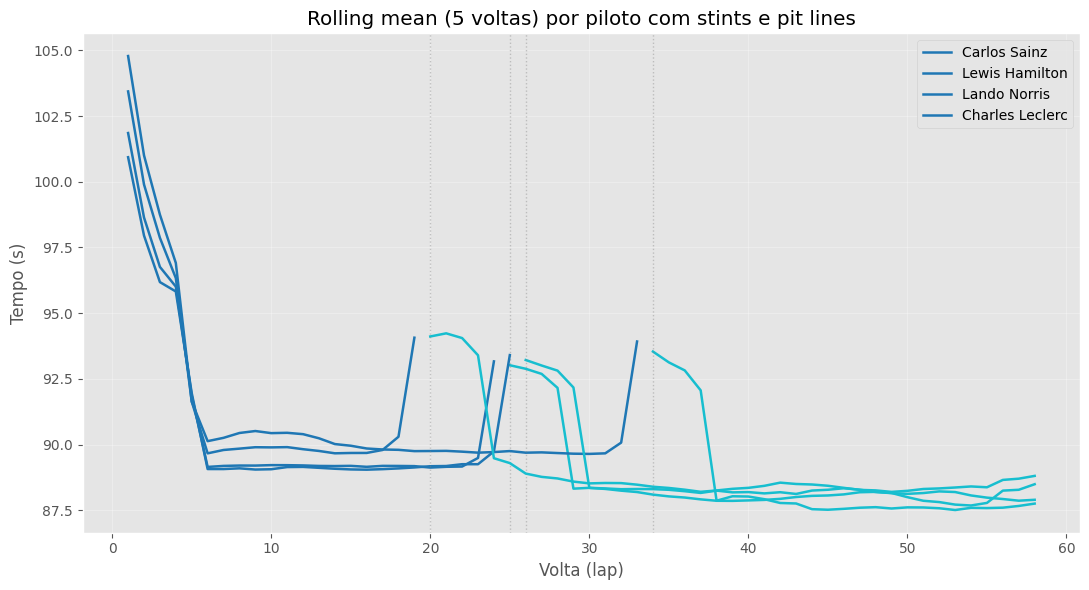

In [82]:
# Rolling mean 5-voltas por piloto com stints e linhas de pit (sem pandas)
from pyspark.sql import functions as F, Window
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt
import numpy as np

if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals() or 'dfs' not in globals():
    raise RuntimeError('Variaveis necessarias nao encontradas. Execute as celulas 2-4.')

DRIVERS_TO_PLOT = 4
WINDOW_HALF = 2  # 2 de cada lado => 5 voltas

base = (selected_race
    .select('driver_full_name','driverId','lap', F.col('milliseconds').alias('ms'))
    .where(F.col('ms').isNotNull())
)
# top drivers por qtd de voltas
top = (base.groupBy('driver_full_name','driverId')
    .agg(F.count('*').alias('laps'))
    .orderBy(F.col('laps').desc())
    .limit(DRIVERS_TO_PLOT)
    .collect())
drivers = [(int(r['driverId']), r['driver_full_name']) for r in top]

# stints: pit_flag cumulativo por driver
raceId_val = int(selected_race.select('raceId').limit(1).collect()[0]['raceId'])
pit = None
if dfs.get('pit_stops') is not None:
    pit = (dfs['pit_stops']
        .filter(F.col('raceId') == raceId_val)
        .select('driverId','lap')
        .distinct())

w_roll = Window.partitionBy('driverId').orderBy('lap').rowsBetween(-WINDOW_HALF, WINDOW_HALF)
w_cum = Window.partitionBy('driverId').orderBy('lap').rowsBetween(Window.unboundedPreceding, 0)
b = base
if pit is not None:
    b = (b.alias('b')
        .join(pit.alias('p'), on=['driverId','lap'], how='left')
        .withColumn('pit_flag', F.when(F.col('p.lap').isNotNull(), F.lit(1)).otherwise(F.lit(0))))
else:
    b = b.withColumn('pit_flag', F.lit(0))
b = b.withColumn('stint', F.sum(F.col('pit_flag')).over(w_cum))
b = b.withColumn('roll_ms', F.avg('ms').over(w_roll))

# Plot
plt.figure(figsize=(11,6))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
stint_colors = ['#1f77b4','#17becf','#2ca02c','#bcbd22','#ff7f0e','#d62728','#9467bd']
for idx, (did, name) in enumerate(drivers):
    data = (b.filter(F.col('driverId') == did)
        .select('lap','roll_ms','stint')
        .orderBy('lap')
        .collect())
    laps = [int(r['lap']) for r in data]
    rolls = [float(r['roll_ms'])/1000.0 if r['roll_ms'] is not None else None for r in data]
    stints = [int(r['stint']) for r in data]
    # Desenha segmentos por stint
    last = 0
    for i in range(1, len(laps)+1):
        if i == len(laps) or stints[i] != stints[i-1]:
            xs = [x for x in laps[last:i] if rolls[laps.index(x)] is not None]
            ys = [rolls[j] for j in range(last, i) if rolls[j] is not None]
            if xs and ys:
                color = stint_colors[stints[i-1] % len(stint_colors)]
                plt.plot(xs, ys, '-', linewidth=1.8, color=color, label=(name if last==0 else None))
            last = i
    # Pit lines
    if pit is not None:
        pit_rows = (pit.filter(F.col('driverId') == did).orderBy('lap').collect())
        for r in pit_rows:
            plt.axvline(x=int(r['lap']), color='gray', linestyle=':', alpha=0.4, linewidth=1)

plt.title('Rolling mean (5 voltas) por piloto com stints e pit lines')
plt.xlabel('Volta (lap)')
plt.ylabel('Tempo (s)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


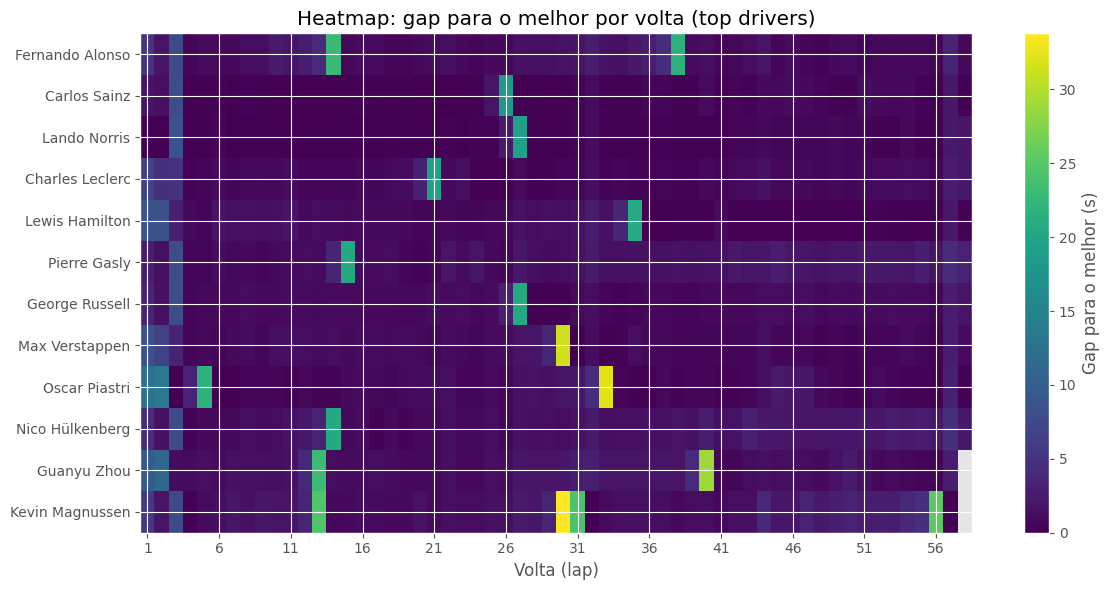

In [83]:
# Heatmap (drivers x lap) de gap para o melhor da volta (sem pandas)
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as _SparkSession
import numpy as np
import matplotlib.pyplot as plt
if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals():
    raise RuntimeError('selected_race nao encontrada. Execute as celulas 1-4.')
TOP_DRIVERS = 12
df = selected_race.select('driver_full_name','driverId','lap', F.col('milliseconds').alias('ms')).where(F.col('ms').isNotNull())
best = df.groupBy('lap').agg(F.min('ms').alias('best_ms'))
gaps = (df.alias('d').join(best.alias('b'), on='lap', how='left').withColumn('gap_s', (F.col('d.ms') - F.col('b.best_ms'))/1000.0))
top = (gaps.groupBy('driver_full_name','driverId').agg(F.count('*').alias('laps')).orderBy(F.col('laps').desc()).limit(TOP_DRIVERS).collect())
driver_ids = [int(r['driverId']) for r in top]
driver_names = [r['driver_full_name'] for r in top]
lr = gaps.agg(F.min('lap').alias('min_lap'), F.max('lap').alias('max_lap')).collect()[0]
min_lap = int(lr['min_lap']); max_lap = int(lr['max_lap']); n_laps = max_lap - min_lap + 1
mat = np.full((len(driver_ids), n_laps), np.nan, dtype=float)
for idx, did in enumerate(driver_ids):
    rows = gaps.filter(F.col('driverId')==did).select('lap','gap_s').collect()
    for r in rows:
        j = int(r['lap']) - min_lap
        if 0 <= j < n_laps:
            mat[idx, j] = float(r['gap_s'])
plt.figure(figsize=(12, max(4, int(len(driver_ids)*0.5))))
im = plt.imshow(mat, aspect='auto', interpolation='nearest', cmap='viridis', origin='upper')
plt.colorbar(im, label='Gap para o melhor (s)')
plt.yticks(ticks=range(len(driver_names)), labels=driver_names)
ticks = list(range(0, n_laps, max(1, n_laps//10)))
labels = [str(min_lap + t) for t in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Volta (lap)'); plt.title('Heatmap: gap para o melhor por volta (top drivers)')
plt.tight_layout(); plt.show()


Mostra: quem se manteve mais próximo do melhor ritmo a cada volta.

Leitura: cores claras = perto do melhor; escuras = longe.

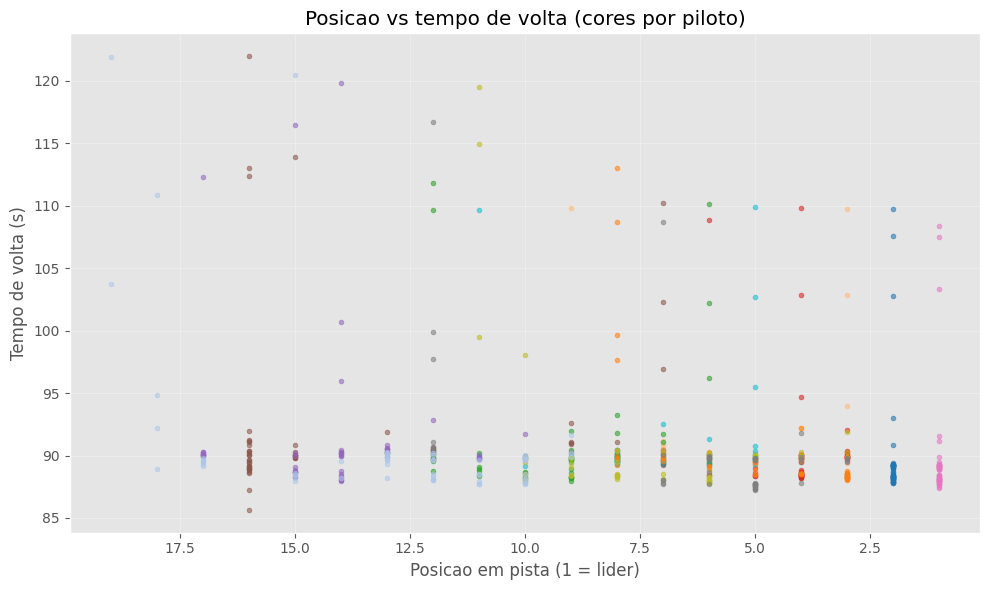

In [85]:
# Scatter: posicao em pista vs tempo de volta (cor por piloto)
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt
if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals():
    raise RuntimeError('selected_race nao encontrada. Execute as celulas 1-4.')
TOP_DRIVERS = 12
df = selected_race.select('driver_full_name','position', (F.col('milliseconds')/1000.0).alias('lap_s')).where(F.col('lap_s').isNotNull())
top = (selected_race.groupBy('driver_full_name').agg(F.count('*').alias('laps')).orderBy(F.col('laps').desc()).limit(TOP_DRIVERS).collect())
keep = set([r['driver_full_name'] for r in top])
rows = df.where(F.col('driver_full_name').isin(list(keep))).collect()
names = sorted(list(keep))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#aec7e8','#ffbb78']
color_map = {name: colors[i % len(colors)] for i, name in enumerate(names)}
plt.figure(figsize=(10,6))
for r in rows:
    name = r['driver_full_name']; pos = int(r['position']) if r['position'] is not None else None; val = float(r['lap_s'])
    if pos is None: continue
    plt.scatter(pos, val, s=12, alpha=0.6, color=color_map.get(name, '#333333'))
plt.gca().invert_xaxis(); plt.xlabel('Posicao em pista (1 = lider)'); plt.ylabel('Tempo de volta (s)')
plt.title('Posicao vs tempo de volta (cores por piloto)'); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


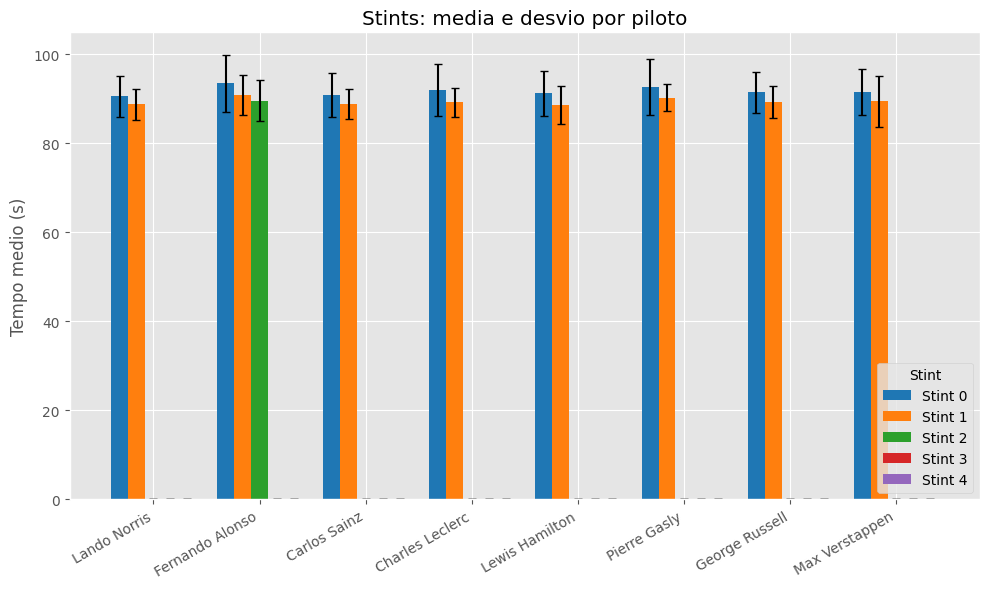

In [86]:
# Stints: barras por piloto com media e desvio por stint (sem pandas)
from pyspark.sql import functions as F, Window
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt
import numpy as np
if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals() or 'dfs' not in globals():
    raise RuntimeError('Variaveis necessarias nao encontradas. Execute as celulas 2-4.')
TOP_DRIVERS = 8
base = selected_race.select('driver_full_name','driverId','lap', (F.col('milliseconds')/1000.0).alias('lap_s')).where(F.col('lap_s').isNotNull())
raceId_val = int(selected_race.select('raceId').limit(1).collect()[0]['raceId'])
pit = None
if dfs.get('pit_stops') is not None:
    pit = dfs['pit_stops'].filter(F.col('raceId')==raceId_val).select('driverId','lap').distinct()
w_cum = Window.partitionBy('driverId').orderBy('lap').rowsBetween(Window.unboundedPreceding, 0)
b = base
if pit is not None:
    b = b.alias('b').join(pit.alias('p'), on=['driverId','lap'], how='left').withColumn('pit_flag', F.when(F.col('p.lap').isNotNull(), 1).otherwise(0))
else:
    b = b.withColumn('pit_flag', F.lit(0))
b = b.withColumn('stint', F.sum('pit_flag').over(w_cum))
top = b.groupBy('driver_full_name','driverId').agg(F.count('*').alias('laps')).orderBy(F.col('laps').desc()).limit(TOP_DRIVERS).collect()
drivers = [(int(r['driverId']), r['driver_full_name']) for r in top]
stats = b.groupBy('driverId','stint').agg(F.avg('lap_s').alias('mean_s'), F.stddev('lap_s').alias('std_s'), F.count('*').alias('n'))
stint_ids = sorted([int(r['stint']) for r in stats.select('stint').distinct().collect()])
bar_width = 0.8 / max(1, len(stint_ids))
x = np.arange(len(drivers))
plt.figure(figsize=(max(10, len(drivers)*1.2), 6))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
for i, st in enumerate(stint_ids):
    means = []; stds = []
    for did,_ in drivers:
        row = stats.filter((F.col('driverId')==did) & (F.col('stint')==st)).select('mean_s','std_s').collect()
        if row:
            means.append(float(row[0]['mean_s']))
            stds.append(float(row[0]['std_s']) if row[0]['std_s'] is not None else 0.0)
        else:
            means.append(0.0); stds.append(0.0)
    plt.bar(x + i*bar_width, means, width=bar_width, yerr=stds, capsize=3, color=colors[i % len(colors)], label='Stint '+str(st))
plt.xticks(x + (len(stint_ids)-1)*bar_width/2.0, [name for _,name in drivers], rotation=30, ha='right')
plt.ylabel('Tempo medio (s)'); plt.title('Stints: media e desvio por piloto')
plt.legend(title='Stint'); plt.tight_layout(); plt.show()


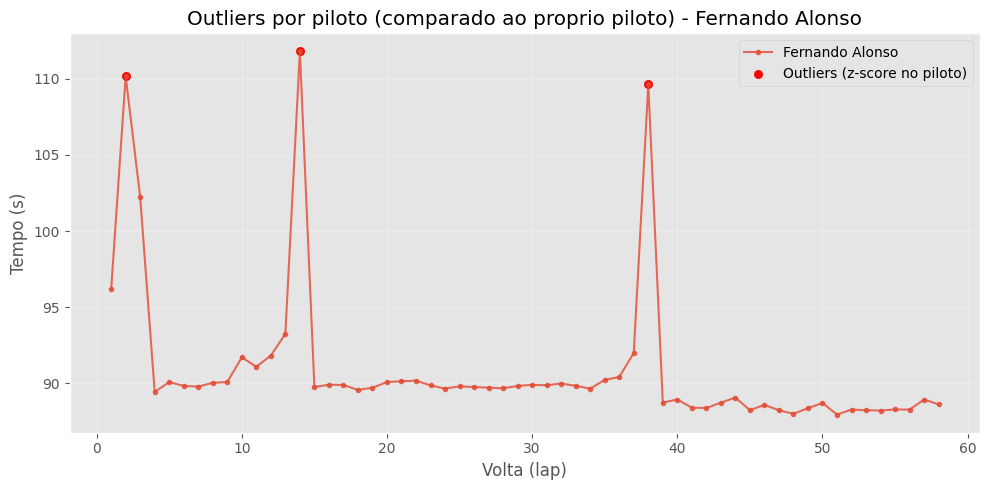

In [87]:
# Outliers por piloto: z-score dentro do proprio piloto (sem pandas)
from pyspark.sql import functions as F
from pyspark.sql import SparkSession as _SparkSession
import matplotlib.pyplot as plt
if 'spark' not in globals() or not isinstance(spark, _SparkSession):
    raise RuntimeError('Sessao Spark nao encontrada. Execute as celulas 1-4.')
if 'selected_race' not in globals():
    raise RuntimeError('selected_race nao encontrada. Execute as celulas 1-4.')
DRIVER_NAME = None; COLUMN_TO_ANALYZE = 'milliseconds'; Z_THRESHOLD = 3.0
base = selected_race.select('driver_full_name','driverId','lap', F.col(COLUMN_TO_ANALYZE).cast('double').alias('y')).where(F.col('y').isNotNull())
if DRIVER_NAME is None:
    top = base.groupBy('driver_full_name','driverId').agg(F.count('*').alias('laps')).orderBy(F.col('laps').desc()).limit(1).collect()
    DRIVER_NAME = top[0]['driver_full_name']; DRIVER_ID = int(top[0]['driverId'])
else:
    di = base.filter(F.col('driver_full_name')==DRIVER_NAME).select('driverId').limit(1).collect()
    if not di: raise RuntimeError('Piloto nao encontrado: ' + str(DRIVER_NAME))
    DRIVER_ID = int(di[0]['driverId'])
df = base.filter(F.col('driverId')==DRIVER_ID)
stats = df.agg(F.avg('y').alias('mean'), F.stddev('y').alias('std')).collect()[0]
mean_v = float(stats['mean']); std_v = float(stats['std']) if stats['std'] is not None else 0.0
rows = df.orderBy('lap').collect()
laps = [int(r['lap']) for r in rows]; ys = [float(r['y'])/1000.0 for r in rows]
is_out = [abs((float(r['y'])-mean_v)/std_v) > Z_THRESHOLD if std_v > 0 else False for r in rows]
plt.figure(figsize=(10,5))
plt.plot(laps, ys, '-o', markersize=3, alpha=0.8, label=DRIVER_NAME)
x_ou = [x for x,o in zip(laps, is_out) if o]; y_ou = [y for y,o in zip(ys, is_out) if o]
if x_ou: plt.scatter(x_ou, y_ou, s=35, color='red', label='Outliers (z-score no piloto)')
plt.xlabel('Volta (lap)'); plt.ylabel('Tempo (s)')
plt.title('Outliers por piloto (comparado ao proprio piloto) - ' + DRIVER_NAME)
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
